Add Robin boundary conditions.

Success!!!

Author: yanjun zhang

## ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [1]:
#### import basic
import pyvista
import ufl
import dolfinx
import time
import numpy as np
import matplotlib.pyplot as plt
from petsc4py import PETSc
from mpi4py import MPI
import sys
import os
import shutil

## import speciail library
from dolfinx.fem.petsc import LinearProblem, assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import Constant, dirichletbc, Function, FunctionSpace,form,locate_dofs_topological
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities,locate_entities_boundary,meshtags
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dx, grad, inner, Measure, dot, FacetNormal
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

## import own functions
from brake_disc_functions import *

########################################### calculate how long time the simulation it is ################
start_time = time.time()

######################################### mesh-size, contact area coefficient ############################
mesh_min = 1
mesh_max = 15
c_contact = 2

########################################## Each time step rotation angular ###############################
degree_rotation = 36000
v_angular_initial = 96.62 

############################################### Start time, Final time  ##################################
t = 0
Total_time = 49
t_lag = 4.2

############################################# calculate total num_steps  ##################################
total_angular = v_angular_initial * t_lag +  (v_angular_initial / 2)  * (Total_time - 4)
total_angular = total_angular / np.pi *180       # rad to degree
num_steps = round( total_angular / degree_rotation )

######################################### rubbing element radius, Contact area  ###########################
r_rub = 18.8
S_rub_circle = r_rub**2 * c_contact
S_contact = S_rub_circle * np.pi
S_total = S_contact * 18  #mm2

######################################### initial and brake pad temperature#########################
Ti = 60
Tm = 60

################################## density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)###############
t_u = 1e3 # m to mm
rho = 7850 /(t_u**3)
c = 462
k = 48 / t_u

######################################## mu, P_brake,  r_disc , heat_distribution  ###############
mu = 0.376
P_initial = 274000
r_disc = 0.25
heat_distribution = 0.88

# D_wheel = 920 mm, v = D_wheel /2 /1000 * v_angular_initial *3.6   # km/h

#dt1 = degree_rotation/180*np.pi / (v_angular_initial)
#num_stops = round (t_lag / dt1)

dt1 = degree_rotation/180*np.pi / ( 96.62 +    (96.62- (96.62/49*4.2) )  ) /2
num_stops = round (t_lag / dt1)
    

P = []
for i in range(num_steps):
    #if i <= num_steps* (t_lag/ Total_time)*2:
    if i <= num_stops:
        P.append(  P_initial/ num_steps  * i  )
    else:
        P.append( P_initial) 

#################################################### time step size ##################################
dt = []
v_angular = [v_angular_initial ]

for i in range(num_steps):
    if i < num_stops:
        dt.append ( degree_rotation/180*np.pi / v_angular[i]  )
        v_angular.append (   96.62- sum(dt)* (96.62/49)  )
    else:
        if v_angular[i] < 0:
           num_steps1 = i
           break
        else:
           dt.append ( degree_rotation/180*np.pi / v_angular[i-1]  )
           v_angular.append ( v_angular[num_stops] -  v_angular[num_stops]/(Total_time - t_lag) * (sum(dt)-t_lag) ) 
   

################################## S_or is the original brake pad rubbing area, 200 cm2. ######################3
S_or = 200
S_new = S_total/100 #mm2 to cm2

############################################# g is the heat source,unit is w/mm2 ###############################
g = []

for i in range(num_steps):
    g.append ( mu * P[i] * v_angular[i] * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) )

num_steps = num_steps

###################################  h is the heat convection coefficient, unit is W/mm2 K  #################
h = 7.75e-5
# radiation is the radiation heat coefficient, unit is W/mm2 K
# stefan-Boltzmann constant theta = 5.67*10e-8 w/m2 k-4,   0.64 is the emmissivity
radiation = 5.670*(10e-8)/(t_u**2)  * 0.64


############################################  print('heat flux g is ',g) #################################
print('1: Time step dt is ',dt[0],'s')
print('2: Convection heat transfer coefficient is',h, ' W/mm2 K')
print('3: Radiation is ',radiation, ' W/mm2 K-4')

total_circle = (v_angular[0] * r_disc * (1/2) * Total_time) / (2*np.pi*r_disc)
total_degree = total_circle * 360
#print('Total circle is ', total_circle,'is equal to ', total_degree )
each_degree = total_degree / num_steps
print('4: Each rotation degree is ', each_degree, ' per time step')
print('5: The first rotation degree is ',v_angular[0] * r_disc * dt[0] *1000 )
print('6: One contact area of rubbing element is ', round(S_contact/100,1), ' cm2')
print('7: Total contact area of 18 rubbing element is', round(S_total/100,1), 'cm2')
print('8: Total numb steps is ', num_steps)

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1: Time step dt is  6.502986242164755 s
2: Convection heat transfer coefficient is 7.75e-05  W/mm2 K
3: Radiation is  3.6287999999999996e-13  W/mm2 K-4
4: Each rotation degree is  33907.49907639334  per time step
5: The first rotation degree is  157079.63267948967
6: One contact area of rubbing element is  22.2  cm2
7: Total contact area of 18 rubbing element is 399.7 cm2
8: Total numb steps is  4


In [2]:
print(num_steps)
print(len(v_angular))

4
5


30.60362119637833


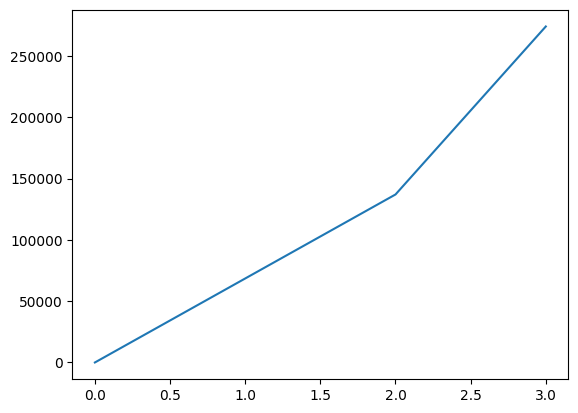

In [3]:
sum_dt = sum(dt)
print(sum_dt)
dt1 = np.linspace(0, 49, num_steps+1)
#plt.plot(dt1 , P)
#plt.plot(v_angular)
#print(dt)
plt.plot(P)
#plt.plot(dt)
#print(v_angular[num_stops] )
#print((sum(dt[:num_stops])-t_lag) )

In [4]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.7.3   based on GIT commit:  ubuntu of https://github.com/FEniCS/dolfinx/


## 2: Mesh

In [5]:
######################################  mesh  ###################################3

mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)  
mesh_filename2 = "m-{}".format(mesh_name)  

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(mesh_filename1, MPI.COMM_WORLD, 0, gdim=3)

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist.")
    mesh_brake_disc(mesh_min, mesh_max,mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(mesh_filename1, MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)
np.set_printoptions(threshold=np.inf)

The file 'm-1-15.msh' exists, start creat now:
Info    : Reading 'm-1-15.msh'...
Info    : 168 entities
Info    : 4281 nodes
Info    : 14875 elements
Info    : Done reading 'm-1-15.msh'


In [6]:
import meshio
mesh1= meshio.read(mesh_filename1)
total_elements = sum( len(cells.data) for cells in mesh1.cells )


## 3: Setup 


In [7]:
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(num_steps, degree_rotation, mesh_filename2,c_contact,total_elements)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(num_steps, degree_rotation, mesh_filename2,c_contact,total_elements)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

In [8]:
# Create boundary condition

x_co, y_co = get_rub_coordinate()

common_indices3,facet_markers3,sorted_indices3 = target_facets(domain,x_co,y_co,S_rub_circle)
      
facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


## 4: Variational equation


In [9]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
xdmf.write_function(uh, t)

#u = ufl.TrialFunction(V)
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (rho*c)/dt[0]*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
- ( inner(f,v) *dx + (rho*c)/dt[0] * inner(u_n, v) * dx +  h * Tm * v *ds(200) +  radiation * (Tm**4)* v *ds(200) )


for i in list(range(1,19)):
     F +=  - k * dot( grad(u)* v, n_vector) *ds(10*i) - inner(g[0], v) *ds(10*i)

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert (converged)


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, degree_rotation, mesh_filename2,c_contact,total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

2024-04-29 19:11:47.253 (   3.305s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:47.279 (   3.331s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:47.297 (   3.350s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0488652 (tol = 1e-10) r (rel) = 1.24473e-05(tol = 1e-06)
2024-04-29 19:11:47.306 (   3.358s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:47.325 (   3.378s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 9.43067e-08 (tol = 1e-10) r (rel) = 2.40224e-11(tol = 1e-06)
2024-04-29 19:11:47.326 (   3.378s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 3 iterations and 17 linear solver iterations.


## 5: Solution


In [10]:

total_degree = 0
for i in range(num_steps):
    t += dt[i]
   
 
    x_co, y_co = rub_rotation (x_co, y_co, each_degree)   # update the location
    total_degree += degree_rotation  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()
    
    common_indices3,facet_markers3,sorted_indices3 = target_facets(domain,x_co,y_co,S_rub_circle)      
    facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 

    F = (rho*c)/dt[i]*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
    - ( inner(f,v) *dx + (rho*c)/dt[i] * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

    for j in list(range(1,19)):
         F +=  - k * dot( grad(u)* v, n_vector) *ds(10*j) - inner(g[i], v) *ds(10*j)

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6
    
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

1: Rotation has applied for 36000 degree. 2: Current time is 6.5 s. 3: Completion is 13.3 %. 

2024-04-29 19:11:50.561 (   6.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:50.562 (   6.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:50.562 (   6.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-29 19:11:50.562 (   6.614s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:50.563 (   6.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:50.563 (   6.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-29 19:11:50.563 (   6.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:50.563 (   6.615s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:50.563 (   6.615s) [mai

1: Rotation has applied for 36000 degree. 2: Current time is 6.5 s. 3: Completion is 13.3 %. 

2024-04-29 19:11:51.311 (   7.363s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:51.311 (   7.363s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:51.312 (   7.364s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:51.312 (   7.364s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:51.314 (   7.366s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:51.319 (   7.371s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-29 19:11:51.338 (   7.390s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:51.370 (   7.422s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 72000 degree. 2: Current time is 14.0 s. 3: Completion is 28.6 %. 

2024-04-29 19:11:51.651 (   7.703s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:51.651 (   7.703s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:51.651 (   7.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-29 19:11:51.652 (   7.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:51.652 (   7.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:51.652 (   7.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-29 19:11:51.652 (   7.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:51.652 (   7.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-29 19:11:51.652 (   7.704s) [mai

1: Rotation has applied for 108000 degree. 2: Current time is 21.5 s. 3: Completion is 43.9 %. 

2024-04-29 19:11:52.297 (   8.350s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:52.298 (   8.350s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:52.298 (   8.350s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:52.298 (   8.350s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:52.299 (   8.351s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:52.305 (   8.358s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-29 19:11:52.323 (   8.375s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:52.351 (   8.403s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 144000 degree. 2: Current time is 30.6 s. 3: Completion is 62.5 %. 

2024-04-29 19:11:53.081 (   9.133s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:53.081 (   9.133s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:53.081 (   9.133s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:53.081 (   9.133s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:53.084 (   9.136s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:53.090 (   9.142s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-29 19:11:53.108 (   9.160s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:53.140 (   9.192s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 144000 degree. 2: Current time is 30.6 s. 3: Completion is 62.5 %. 

2024-04-29 19:11:53.857 (   9.909s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:53.857 (   9.909s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:53.857 (   9.909s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:53.857 (   9.910s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-29 19:11:53.859 (   9.912s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-29 19:11:53.865 (   9.917s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-29 19:11:53.888 (   9.940s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-04-29 19:11:53.916 (   9.968s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

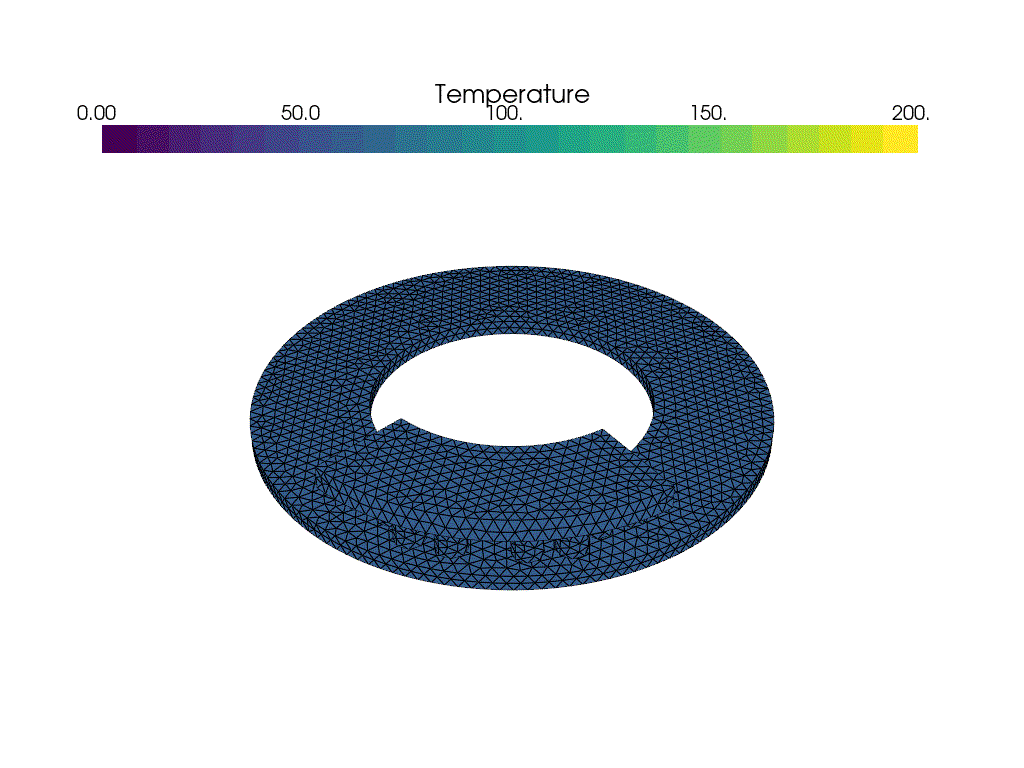

In [11]:
# Display the GIF
from IPython.display import display, Image
display( Image(gif_name) )

In [12]:
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

if elapsed_time1 >= 60:
   min = elapsed_time1/60
   print("Simulation time is",round(min),'min or',elapsed_time1,'second for', num_steps, 'steps')
else:
    print("Simulation time is",elapsed_time1,'second for', num_steps, 'steps')
    

Simulation time is 10.0 second for 4 steps


In [13]:
print('1: First time step dt is ', round(dt[0],5),'s')
print()
print('2: Convection heat transfer coefficient is',h, ' W/mm2 K')
print()
print('3: Radiation is ', round(radiation,14), ' W/mm2 K-4')
print()
print('4: Each rotation degree is ', round(each_degree,1), ' per time step', 'or ', round(each_degree/360,1),' circle')
print()
print('5: The first rotation degree is ', round(v_angular[0] * r_disc * dt[0] *1000, 1) )
print()
print('6: The mid rotation degree is ', round(v_angular[ round(num_steps/2) ] * r_disc * dt[ round(len(dt)/2) ] *1000, 1) )
print()
print('7: The last rotation degree is ', round(v_angular[num_steps-1] * r_disc * dt[-1] *1000, 1) )
print()
print('8: One contact area of rubbing element is ', round(S_contact/100,1), ' cm2')
print()
print('9: Total contact area of 18 rubbing element is', round(S_total/100,1), 'cm2')
print()
print('10: The mesh element size is between ',mesh_min, '-',mesh_max )
print()
print('11: Total elements number is ',total_elements )

1: First time step dt is  6.50299 s

2: Convection heat transfer coefficient is 7.75e-05  W/mm2 K

3: Radiation is  3.6e-13  W/mm2 K-4

4: Each rotation degree is  33907.5  per time step or  94.2  circle

5: The first rotation degree is  157079.6

6: The mid rotation degree is  129364.8

7: The last rotation degree is  96424.6

8: One contact area of rubbing element is  22.2  cm2

9: Total contact area of 18 rubbing element is 399.7 cm2

10: The mesh element size is between  1 - 15

11: Total elements number is  14875


## 6: Simulation time  10 precossors


1: Simulation time is 41 min or 2480.0 second,  T-s-1000-m-3-10-c-1-e-43604.\
2: Simulation time is 9 min or 527.0 second , T-s-1000-m-3-12-c-1-e-25655. \
3:


## 7:Transfer files

In [14]:

# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Tutorial/Calculation"

# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{degree_rotation}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [
                 gif_name,
                 h5_name,
                 xdmf_name
                           ]

# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    shutil.move(source_file_path, destination_file_path)
    print(f"Moved {filename} to {destination_file_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/yanjun/Documents/FEniCSx/Tutorial/Calculation/T-s-4-d-36000-m-1-15-c-2-e-14875.gif'